In [1]:
using CUDA
using Plots
using Adapt
using Pkg
using FFTW
using Pkg
using LaTeXStrings
gr()

Plots.GRBackend()

In [2]:
Pkg.develop(path="C:/Users/hayde/Desktop/University_of_Southampton_files/2024-2025_Summer_research/GPU_CFD_solver/kolomogorov_GPU_mask/kGPU_M")

   Resolving package versions...
  No Changes to `C:\Users\hayde\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\hayde\.julia\environments\v1.11\Manifest.toml`


In [3]:
import kGPU_M

In [4]:
Pkg.test("kGPU_M")

     Testing kGPU_M
      Status `C:\Users\hayde\AppData\Local\Temp\jl_jl8zzk\Project.toml`
  [621f4979] AbstractFFTs v1.5.0
  [79e6a3ab] Adapt v4.3.0
  [052768ef] CUDA v5.8.3
⌃ [7a1cc6ca] FFTW v1.9.0
  [871f8503] kGPU_M v0.1.0 `C:\Users\hayde\Desktop\University_of_Southampton_files\2024-2025_Summer_research\GPU_CFD_solver\kolomogorov_GPU_mask\kGPU_M`
  [8dfed614] Test v1.11.0
      Status `C:\Users\hayde\AppData\Local\Temp\jl_jl8zzk\Manifest.toml`
  [621f4979] AbstractFFTs v1.5.0
  [79e6a3ab] Adapt v4.3.0
  [a9b6321e] Atomix v1.1.2
  [13072b0f] AxisAlgorithms v1.1.0
  [ab4f0b2a] BFloat16s v0.5.1
  [fa961155] CEnum v0.5.0
  [052768ef] CUDA v5.8.3
  [1af6417a] CUDA_Runtime_Discovery v1.0.0
  [d360d2e6] ChainRulesCore v1.26.0
  [3da002f7] ColorTypes v0.12.1
  [5ae59095] Colors v0.13.1
  [34da2185] Compat v4.18.0
  [a8cc5b0e] Crayons v4.1.1
  [9a962f9c] DataAPI v1.16.0
⌃ [a93c6f00] DataFrames v1.7.1
  [864edb3b] DataStructures v0.19.1
  [e2d170a0] DataValueInterfaces v1.0.0
  [e2ba6199] E

In [5]:
print_dir = "C:/Users/hayde/Desktop/University_of_Southampton_files/2024-2025_Summer_research/GPU_CFD_solver/package_testing/verification_plots/"

"C:/Users/hayde/Desktop/University_of_Southampton_files/2024-2025_Summer_research/GPU_CFD_solver/package_testing/verification_plots/"

In [6]:
dt = 0.01
Re = 40.0
max_iter = 10000

xlen = 100
ylen = 100

xlen_padded = 150;
ylen_padded = 150;

xs_padded_full = LinRange(0, 2pi, xlen_padded+1);
ys_padded_full = LinRange(0, 2pi, ylen_padded+1);

xs = CuArray(xs_padded_full[1:xlen_padded]);
ys = CuArray(ys_padded_full[1:ylen_padded]);

ω0 = rand(xlen_padded, ylen_padded)
forcing_freq = 4

function source_fn(x, y)
    return -forcing_freq * cos(forcing_freq * y);
end;

source = [source_fn(x, y) for x in xs, y in ys];
source_hat = rfft(source);


┌ Warning: Performing scalar indexing on task Task (runnable, started) @0x0000026499acf650.
│ Invocation of getindex resulted in scalar indexing of a GPU array.
│ This is typically caused by calling an iterating implementation of a method.
│ Such implementations *do not* execute on the GPU, but very slowly on the CPU,
│ and therefore should be avoided.
│ 
│ If you want to allow scalar iteration, use `allowscalar` or `@allowscalar`
│ to enable scalar iteration globally or for the operations in question.
└ @ GPUArraysCore C:\Users\hayde\.julia\packages\GPUArraysCore\aNaXo\src\GPUArraysCore.jl:145


In [7]:
solver_GPU = kGPU_M.solver{CuArray, kGPU_M.GPU_rfft_type64, kGPU_M.GPU_irfft_type64}();
kGPU_M.init_solver(solver_GPU, dt, Re, max_iter, xs, ys, xlen, ylen, ω0, source_hat, forcing_freq);


In [8]:
niter = 10000
kGPU_M.run(solver_GPU, niter);

In [9]:
#solver_CPU = Adapt.adapt_structure(Array, solver_GPU)
measures = kGPU_M.flow_measures{CuArray}(solver_GPU)
temp_arr = CuArray(repeat([0.0], xlen_padded, ylen_padded))


for i in 1:niter
    kGPU_M.calc_flow_measures(solver_GPU, measures, i, temp_arr);
end;

In [13]:
solver_CPU = Adapt.adapt_structure(Array, solver_GPU);
ω_arr = kGPU_M.calc_physical_data(solver_CPU);

In [14]:
numlevels = 25
max1 = maximum(ω_arr)
min1 = minimum(ω_arr)
levels1 = Array(LinRange(min1, max1, numlevels));



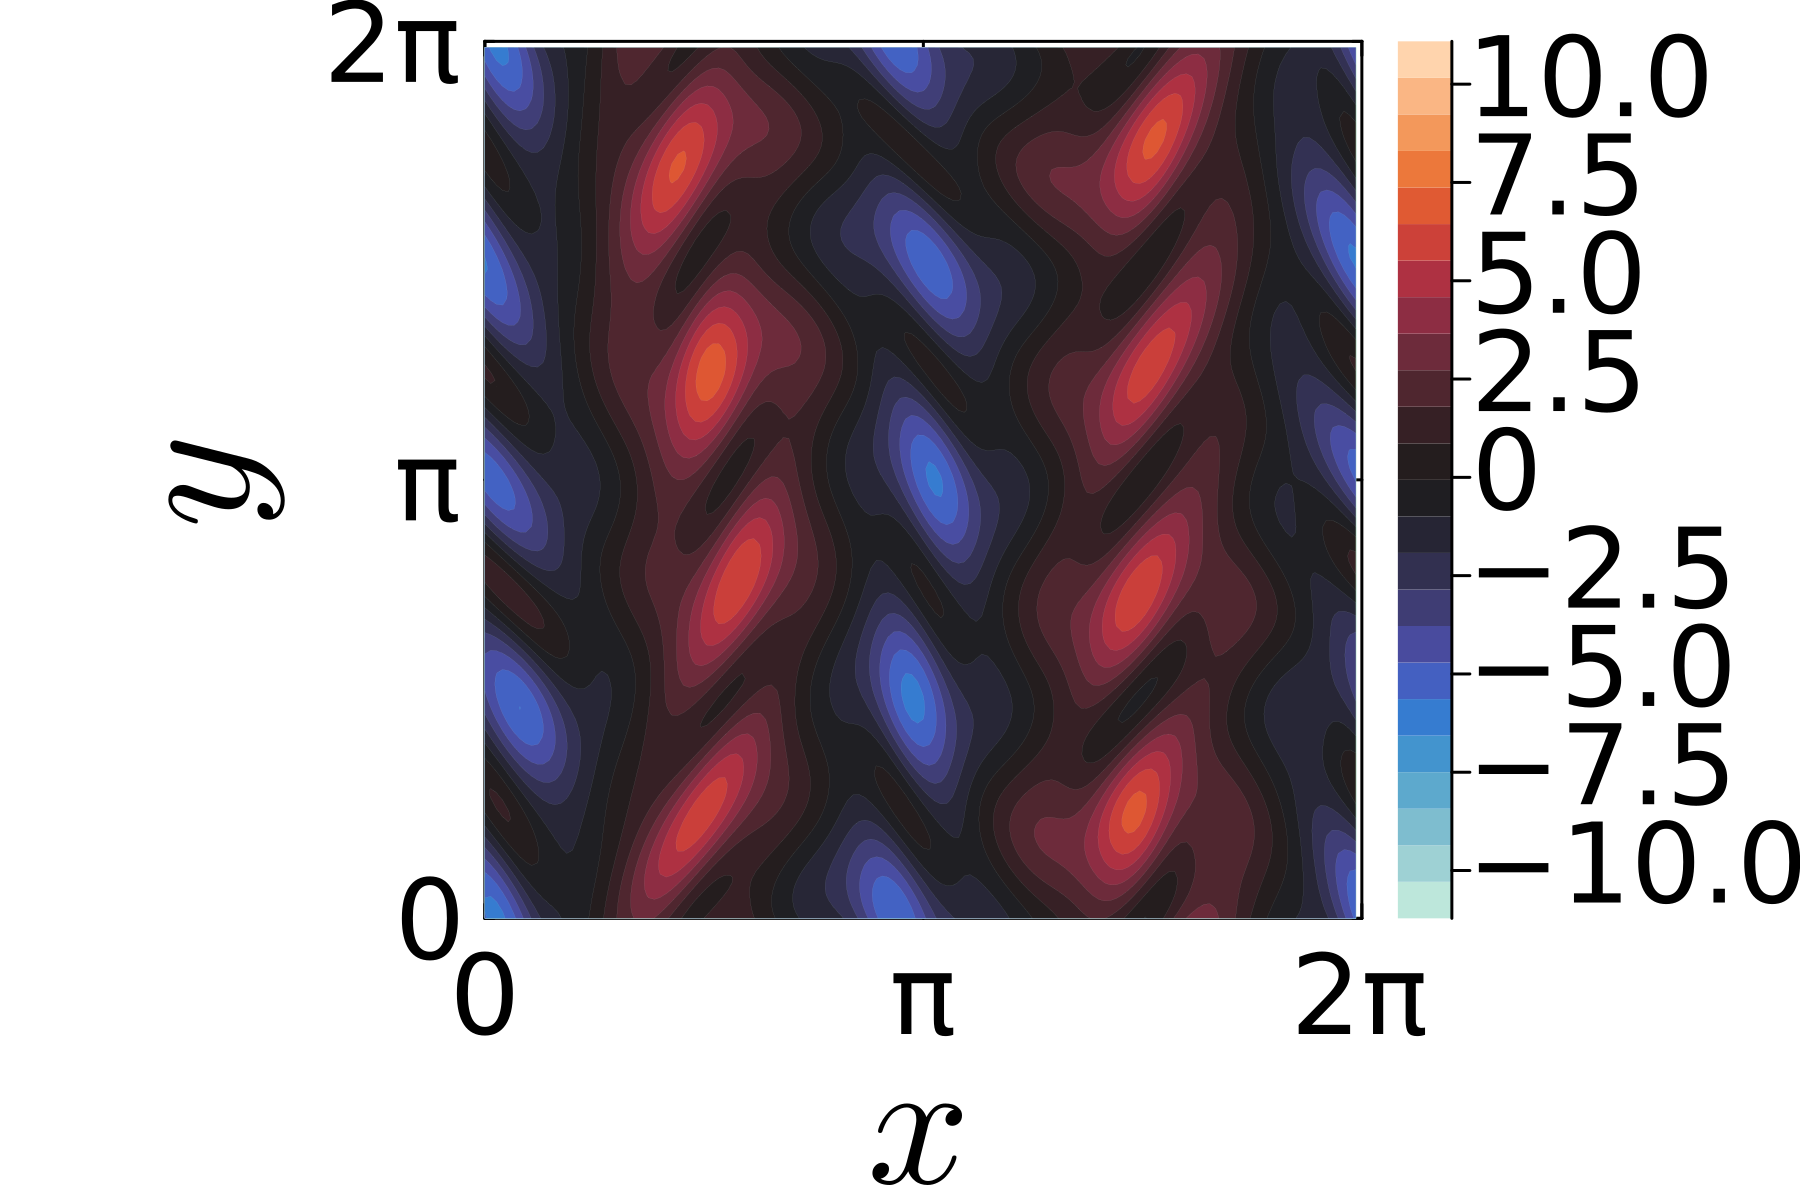

In [15]:
contourf(xs, ys, transpose(ω_arr[:, :, 800]), levels=levels1, c=:seaborn_icefire_gradient, aspect_ratio=1.0, linewidth=0.0, 
    xticks=([0, pi, 2pi], ["0", "π", "2π"]), yticks=([0, pi, 2pi], ["0", "π", "2π"]), framestyle=:box, xlimits=(0, 2pi), ylimits=(0, 2pi), dpi=300, cbar_lims=(min1, max1), xtickfontsize=25, ytickfontsize=25,
        top_margin=1.5Plots.mm, right_margin=7Plots.mm)
xlabel!(L"$x$", xguidefontsize=40)
ylabel!(L"$y$", yguidefontsize=40)
#savefig("$(print_dir)/t8.0.png")

In [34]:
for i in 1:100
    iter_num = i * 100;
    time = convert(Float64, iter_num / 100);
    
    contourf(xs, ys, transpose(ω_arr[:, :, iter_num]), levels=levels1, c=:seaborn_icefire_gradient, aspect_ratio=1.0, linewidth=0.0, 
        xticks=([0, pi, 2pi], ["0", "π", "2π"]), yticks=([0, pi, 2pi], ["0", "π", "2π"]), framestyle=:box, xlimits=(0, 2pi), ylimits=(0, 2pi), dpi=300, cbar_lims=(min1, max1), xtickfontsize=25, ytickfontsize=25,
        top_margin=1.5Plots.mm, right_margin=7Plots.mm)
    xlabel!(L"$x$", xguidefontsize=40)
    ylabel!(L"$y$", yguidefontsize=40)
    #savefig("$(print_dir)/t$time.png")
end;

In [35]:
D_lam = Re / (2 * forcing_freq^2)

1.25

In [36]:
EIR_arr = Array(measures.EIR ./ D_lam)
DR_arr = Array(measures.dissipation_rate ./ D_lam);

In [38]:
plot(EIR_arr, DR_arr, label="EIR-DR", left_margin=10Plots.mm, bottom_margin=5Plots.mm, color=:blue, dpi=300)
xlabel!(L"\frac{EIR}{D_{lam}}")
ylabel!(L"\frac{DR}{D_{lam}}")
savefig("$(print_dir)/EIR-DR.png")

"C:\\Users\\hayde\\Desktop\\University_of_Southampton_files\\2024-2025_Summer_research\\GPU_CFD_solver\\package_testing\\verification_plots\\EIR-DR.png"